In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torchvision.transforms as T

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)



In [ ]:
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


In [ ]:
class Unet(torch.nn.Module):
    def __init__(self):
        super(Unet,self).__init__()
        self.down1 = self.UnetDoubleConv(3,64)
        self.down2 = self.UnetDoubleConv(64,128)
        self.down3 = self.UnetDoubleConv(128,256)
        self.down4 = self.UnetDoubleConv(256,512)
        self.down5 = self.UnetDoubleConv(512,1024)

        self.up1 = self.UnetDoubleConv(64,82)
        self.up2 = self.UnetDoubleConv(128,64)
        self.up3 = self.UnetDoubleConv(256,128)
        self.up4 = self.UnetDoubleConv(512,256)
        self.up5 = self.UnetDoubleConv(1024,512)

        self.upConvT2 = self.UnetUpConv(128,64)
        self.upConvT3 = self.UnetUpConv(256,128)
        self.upConvT4 = self.UnetUpConv(512,256)
        self.upConvT5 = self.UnetUpConv(1024,512)

        self.softmax = torch.nn.Softmax(dim=1)

        self.final = nn.Conv2d(82,82,1,padding='same')


    def UnetDoubleConv(self,in_channels,out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def UnetUpConv(self,in_channels,out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,2,2),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        convOut1 = self.down1(x)
        maxPool1 = nn.MaxPool2d(2)(convOut1)
        convOut2 = self.down2(maxPool1)
        maxPool2 = nn.MaxPool2d(2)(convOut2)
        convOut3 = self.down3(maxPool2)

        upPool3 = self.upConvT3(convOut3)
        upPool3Cat = torch.cat([upPool3,convOut2],dim=1)
        incConvOut2 = self.up3(upPool3Cat)
        upPool2 = self.upConvT2(incConvOut2)
        upPool2Cat = torch.cat([upPool2,convOut1],dim=1)
        incConvOut1 = self.up2(upPool2Cat)

        out1 = self.up1(incConvOut1)
        out = self.final(out1)

        return(out)



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
import copy
from torch.utils.data import Dataset, DataLoader
import math

def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

### Download data and unzip dataset

In [ ]:
!gdown 1lBrqsnPu7RXB0IOjwilS3DYVkKOPs9ui
!unzip training_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_data_filtered/training_data/v2.2/1-6-0_meta.pkl  
  inflating: training_data_filtered/training_data/v2.2/2-168-12_label_kinect.png  
  inflating: training_data_filtered/training_data/v2.2/2-29-2_color_kinect.png  
  inflating: training_data_filtered/training_data/v2.2/1-84-0_meta.pkl  
  inflating: training_data_filtered/training_data/v2.2/2-213-38_meta.pkl  
  inflating: training_data_filtered/training_data/v2.2/2-209-30_color_kinect.png  
  inflating: training_data_filtered/training_data/v2.2/2-45-9_meta.pkl  
  inflating: training_data_filtered/training_data/v2.2/2-35-17_color_kinect.png  
  inflating: training_data_filtered/training_data/v2.2/1-47-1_label_kinect.png  
  inflating: training_data_filtered/training_data/v2.2/1-54-6_depth_kinect.png  
  inflating: training_data_filtered/training_data/v2.2/2-28-34_depth_kinect.png  
  inflating: training_data_filtered/training_data/v2.2/1-53-1_meta.pkl  
  inflatin

# Unzip and load paths

In [ ]:
# Load data
training_data_dir = "./training_data_filtered/training_data/v2.2"
split_dir = "./training_data_filtered/training_data/splits/v2"

In [ ]:
def get_split_files(split_name):
    with open(split_dir + f"/{split_name}.txt", 'r') as f:
        prefix = [os.path.join(training_data_dir, line.strip()) for line in f if line.strip()]
        rgb = [p + "_color_kinect.png" for p in prefix]
        depth = [p + "_depth_kinect.png" for p in prefix]
        label = [p + "_label_kinect.png" for p in prefix]
        meta = [p + "_meta.pkl" for p in prefix]
    return rgb, depth, label, meta

In [ ]:
from matplotlib.cm import get_cmap
NUM_OBJECTS = 79
cmap = get_cmap('rainbow', NUM_OBJECTS)
COLOR_PALETTE = np.array([cmap(i)[:3] for i in range(NUM_OBJECTS + 3)])
COLOR_PALETTE = np.array(COLOR_PALETTE * 255, dtype=np.uint8)
COLOR_PALETTE[-3] = [119, 135, 150]
COLOR_PALETTE[-2] = [176, 194, 216]
COLOR_PALETTE[-1] = [255, 255, 225]

<ipython-input-9-80c26a906e79>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('rainbow', NUM_OBJECTS)


In [ ]:
# from torchsummary import summary
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Loading model to:{DEVICE}")
model = Unet().to(DEVICE)

# summary(model, (3,180,320))

Loading model to:cuda


In [ ]:
# hyper parameters

IMAGE_HEIGHT = 360
IMAGE_WIDTH = 640

num_epochs = 4
batch_size = 4
learning_rate = 0.004

# device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class SegmentationDataset(Dataset):
    def __init__(self, term = 'train', transform=None):
        self.term = term
        rgb_files, depth_files, label_files, meta_files = get_split_files(self.term)
        self.image_dir = rgb_files
        self.mask_dir = label_files
        self.transform = transform


    def __len__(self):
        return len(self.image_dir)

    def __getitem__(self, index):

        image = np.array(Image.open(self.image_dir[index])) / 255
        mask = np.array(Image.open(self.mask_dir[index]))

#         image = image[::4, ::4]
#         mask = mask[::4, ::4]

        image = image[::2, ::2]
        mask = mask[::2, ::2]

        image = torch.from_numpy(image.astype(np.float32))
        mask = torch.from_numpy(mask.astype(np.int64))


        return image, mask

In [ ]:
dataset = SegmentationDataset()

dataloader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True, num_workers = 0, drop_last = True)

# Next 4 lines are just to see the data for batch_size = 4 and NOT a part of pipeline

dataiter = iter(dataloader)
data = next(dataiter)
imgs, edgs = data
print(imgs.shape, edgs.shape)

torch.Size([4, 360, 640, 3]) torch.Size([4, 360, 640])


In [ ]:
# model = UNET(in_channels=3, out_channels=82)
model = Unet()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
# Training loop
n_total_steps = len(dataloader)   # n_total_steps = total num samples in dataset / batch_size

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader):

        images = images.permute(0,3,1,2).to(device)
        labels = labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Gradients
        optimizer.zero_grad()
        loss.backward()

        # Weights update
        optimizer.step()

        if (i+1) %100 == 0:
            print(f'epoch: {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss}')

epoch: 1/4, step 100/991, loss = 0.07664191722869873
epoch: 1/4, step 200/991, loss = 0.04328831657767296
epoch: 1/4, step 300/991, loss = 0.020189005881547928
epoch: 1/4, step 400/991, loss = 0.020694108679890633
epoch: 1/4, step 500/991, loss = 0.012464453466236591
epoch: 1/4, step 600/991, loss = 0.010566960088908672
epoch: 1/4, step 700/991, loss = 0.012113270349800587
epoch: 1/4, step 800/991, loss = 0.004580342676490545
epoch: 1/4, step 900/991, loss = 0.005901570897549391
epoch: 2/4, step 100/991, loss = 0.01690186746418476
epoch: 2/4, step 200/991, loss = 0.01485480647534132
epoch: 2/4, step 300/991, loss = 0.009488171897828579
epoch: 2/4, step 400/991, loss = 0.0039725350216031075
epoch: 2/4, step 500/991, loss = 0.0035901807714253664
epoch: 2/4, step 600/991, loss = 0.001887646270915866
epoch: 2/4, step 700/991, loss = 0.0024528636131435633
epoch: 2/4, step 800/991, loss = 0.002366872737184167
epoch: 2/4, step 900/991, loss = 0.0029865235555917025
epoch: 3/4, step 100/991, lo

In [ ]:
PATH = './segmentation_model_halfsize.pth'
torch.save(model.state_dict(), PATH)

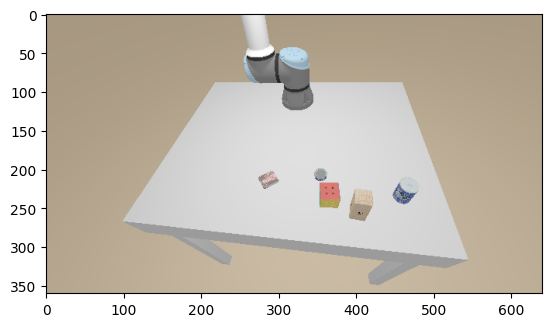

In [ ]:
plt.imshow(np.transpose(images.cpu().detach().numpy()[0],(1,2,0)))

In [ ]:
dataiter = iter(dataset)
d = next(dataiter)
image, label = d

In [ ]:
d = next(dataiter)
image, label = d

In [ ]:
torch.unsqueeze(image.permute(2,0,1),0).shape

torch.Size([1, 3, 360, 640])

In [ ]:
image.shape

torch.Size([360, 640, 3])

In [ ]:
dis_label = np.argmax(torch.squeeze(model(torch.unsqueeze(image.permute(2,0,1),0).to(DEVICE)),0).cpu().detach().numpy(),0)

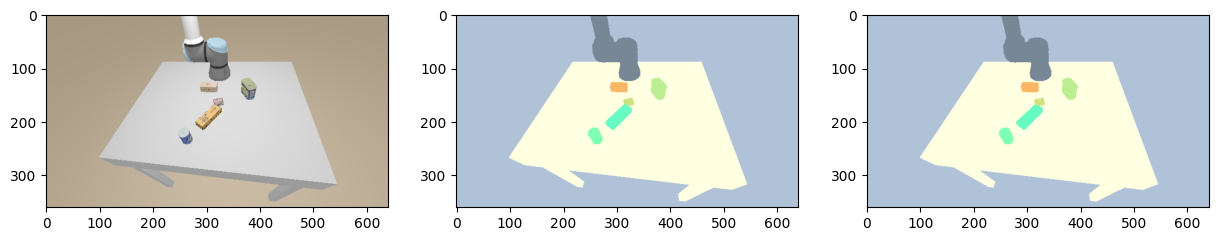

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.subplot(1, 3, 2)
plt.imshow(COLOR_PALETTE[label])
plt.subplot(1, 3, 3)
plt.imshow(COLOR_PALETTE[dis_label])  # draw colorful segmentation

In [ ]:
PATH = './segmentation_model1.pth.tar'
torch.save(model.state_dict(), PATH)